## Modeling EarthQuake Damage

### Importing Libraries

In [1]:
# Importing Basic Libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# Importing Viz Libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,5)

# Importing Light Gradient Boosting Model
import lightgbm as lgb

# Importing Keras - For NN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Import Metrics and KFold Splits
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

### Loading and Combining Datasets

In [2]:
train = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test = pd.read_csv("test_values.csv")

In [3]:
print('Training Variables')
train.head()

Training Variables


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [4]:
print('Training Labels')
train_labels.head()

Training Labels


,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [5]:
print("Train Feature Shape: ",train.shape)
print("Train Label Shape: ",train_labels.shape)

Train Feature Shape:  (260601, 39)
Train Label Shape:  (260601, 2)


##### Checking Uniqueness and Merging the DataSets

In [6]:
train.groupby(['building_id']).size().reset_index(name='count').sort_values(['count'],ascending=False).head(2)

,building_id,count
0,4,1
173739,701197,1


In [7]:
train_labels.groupby(['building_id']).size().reset_index(name='count').sort_values(['count'],ascending=False).head(2)

,building_id,count
0,4,1
173739,701197,1


In [8]:
train = pd.merge(train, train_labels, left_on=['building_id'], right_on=['building_id'], how = 'left')

In [9]:
print('Training Data')
train.head()

Training Data


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


### Data Exploration

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

There are no missing or Null values

##### Correlation Plot for Initial Diagnosis

<AxesSubplot:>

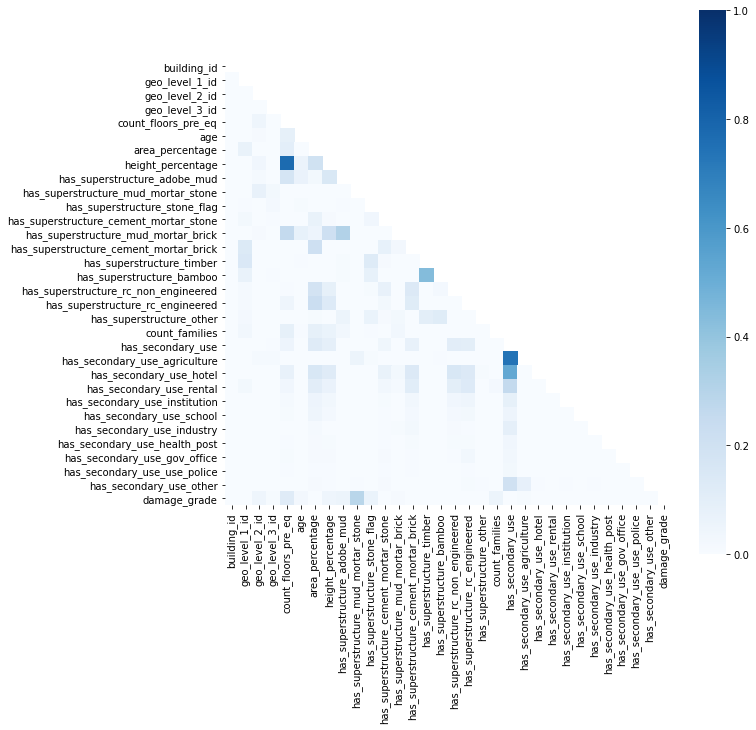

In [11]:
plt.subplots(figsize=(10,10))
corr = train.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)
sns.heatmap(corr, xticklabels=True, yticklabels=True, mask=matrix, vmin=0, vmax=1, square=True, cmap='Blues')

1. There are no explicit correlation of the features with damage grade
2. Height Percentage is correlated with No. of Floors which makes sense

Text(0.5, 1.0, 'Damage Grade Distribution')

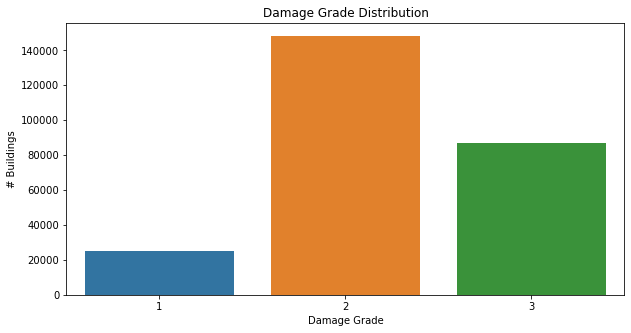

In [12]:
sns.countplot(train['damage_grade'])
plt.xlabel('Damage Grade')
plt.ylabel('# Buildings')
plt.title('Damage Grade Distribution')

Text(0.5, 1.0, 'Distribution of Floors')

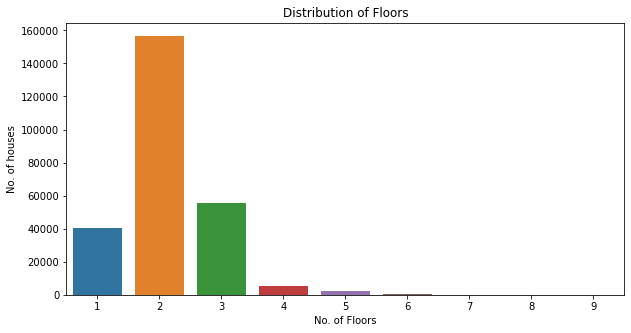

In [13]:
sns.countplot(train['count_floors_pre_eq'])
plt.xlabel('No. of Floors')
plt.ylabel('No. of houses')
plt.title('Distribution of Floors')

Most of the buildings had 2 floors. Buildings with more than 4 floors are rare.

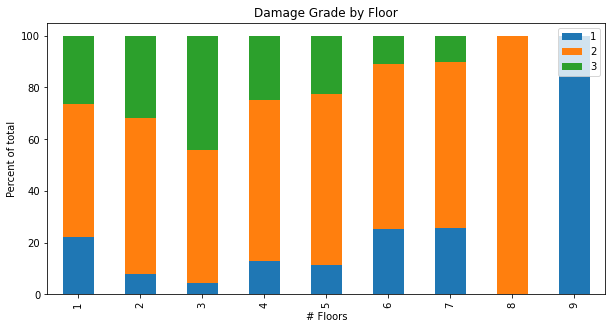

In [14]:
dataGrouped=train.groupby(['count_floors_pre_eq','damage_grade' ]).agg({'building_id':'count'}).reset_index()

dataGrouped.rename(columns={'building_id':'count'},inplace=True)

dataCrosstab=pd.crosstab(index=dataGrouped['count_floors_pre_eq'],columns=dataGrouped['damage_grade'],
                         values=dataGrouped['count'], aggfunc='sum',normalize='index')*100

dataCrosstab.plot(kind='bar',stacked=True,title='Damage Grade by Floor')
plt.legend(loc='best')
plt.ylabel('Percent of total')
plt.xlabel('# Floors')
plt.legend(loc='upper right')

We observe an ordinality in the data. As the number of floor increases the higher the chance of severe damange to the building. <br>
The ordinality is not observed after 4 or more floor onwards as there aren't significant number of observations.

Text(0.5, 1.0, 'Distribution of Age of the house')

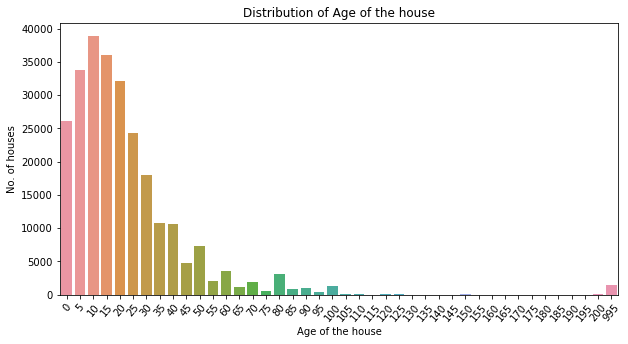

In [15]:
sns.countplot(train['age'])
plt.xlabel('Age of the house')
plt.xticks(rotation = 50)
plt.ylabel('No. of houses')
plt.title('Distribution of Age of the house')

There are fewer buildings above 100 years old. Buildings above the age of 100 can be considered as outlier.

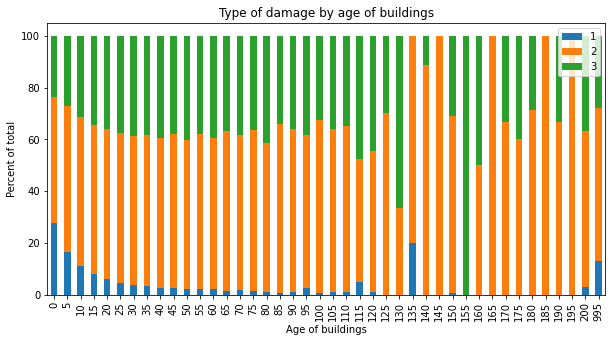

In [16]:
dataGrouped=train.groupby(['age','damage_grade' ]).agg({'building_id':'count'}).reset_index()

dataGrouped.rename(columns={'building_id':'count'},inplace=True)

dataCrosstab=pd.crosstab(index=dataGrouped['age'],columns=dataGrouped['damage_grade'],
                         values=dataGrouped['count'], aggfunc='sum',normalize='index')*100

dataCrosstab.plot(kind='bar',stacked=True,title='Type of damage by age of buildings')
plt.legend(loc='best')
plt.ylabel('Percent of total')
plt.xlabel('Age of buildings')
plt.legend(loc='upper right')

Again we observe an ordinality in the data. As the age increases there is higher the chance of severe damange to the building. <br>
The ordinality is not observed after above 100 years as there aren't significant number of observations.

In [17]:
struct_feat = ['has_superstructure_adobe_mud','has_superstructure_mud_mortar_stone','has_superstructure_stone_flag',\
 'has_superstructure_cement_mortar_stone','has_superstructure_mud_mortar_brick',\
 'has_superstructure_cement_mortar_brick','has_superstructure_timber','has_superstructure_bamboo',\
 'has_superstructure_rc_non_engineered','has_superstructure_rc_engineered','has_superstructure_other']

Text(0.5, 1.0, 'Damage Grade by Building Type')

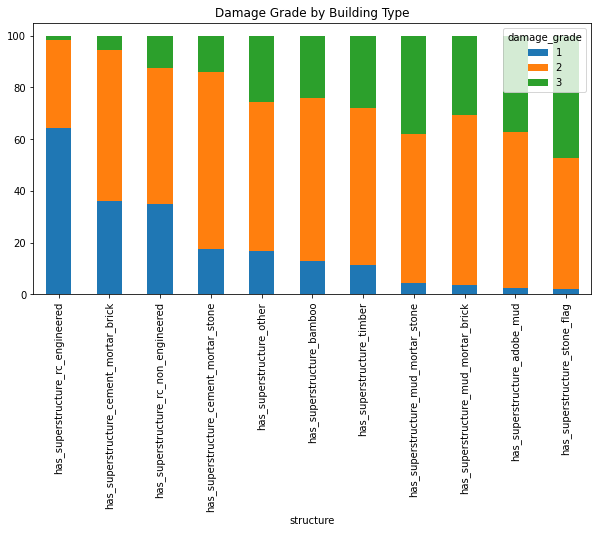

In [18]:
datamelt=train.melt(id_vars=['age','damage_grade'],value_vars=struct_feat).rename(columns={'variable':'structure','value':'count'})

damageByStructure=datamelt.groupby(['damage_grade','structure']).agg({'count':'sum'})

damageByStructure.reset_index(inplace=True)

damageByStructure.sort_values(by='count', ascending=False,inplace=True)

StructCrosstab=pd.crosstab(index=damageByStructure['structure'],columns=damageByStructure['damage_grade'],
                         values=damageByStructure['count'], aggfunc='sum',normalize='index')*100

StructCrosstab.sort_values([1,2,3],inplace=True,ascending=False)

StructCrosstab.plot(kind='bar',stacked=True)
plt.title('Damage Grade by Building Type')

The above chart reveals that the stronger the materials used to construct the buildings lesser the damage is. 

<AxesSubplot:xlabel='foundation_type', ylabel='count'>

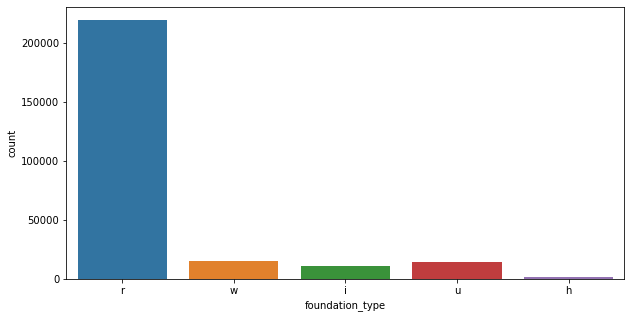

In [19]:
sns.countplot(train['foundation_type'])

<AxesSubplot:xlabel='land_surface_condition', ylabel='count'>

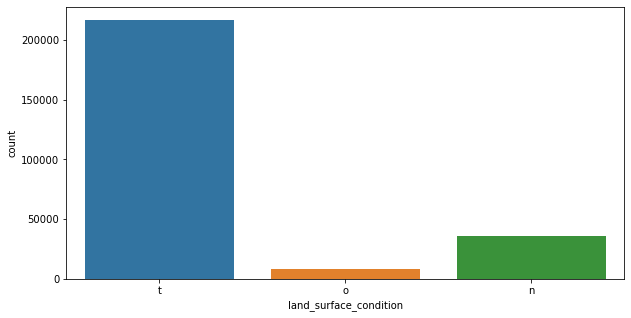

In [20]:
sns.countplot(train['land_surface_condition'])

Text(0.5, 0, 'Roof Top Type')

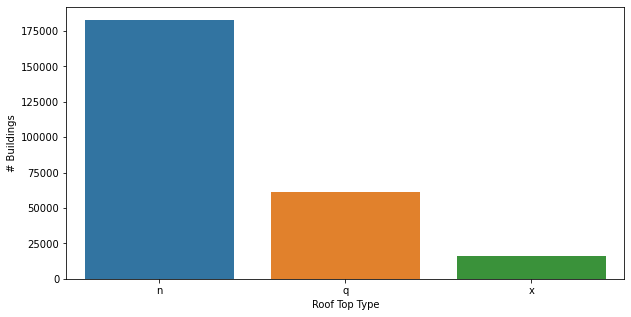

In [21]:
sns.countplot(train['roof_type'])
plt.ylabel('# Buildings')
plt.xlabel('Roof Top Type')

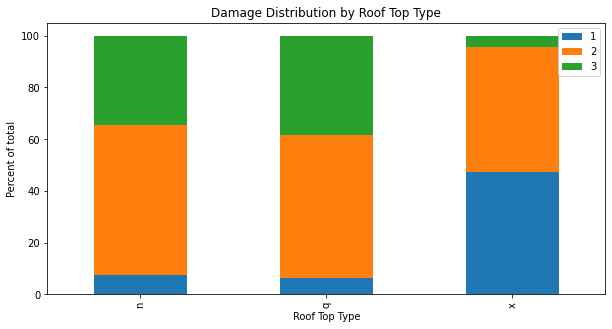

In [22]:
dataGrouped=train.groupby(['roof_type','damage_grade' ]).agg({'building_id':'count'}).reset_index()

dataGrouped.rename(columns={'building_id':'count'},inplace=True)

dataCrosstab=pd.crosstab(index=dataGrouped['roof_type'],columns=dataGrouped['damage_grade'],
                         values=dataGrouped['count'], aggfunc='sum',normalize='index')*100

dataCrosstab.plot(kind='bar',stacked=True,title='Damage Distribution by Roof Top Type')
plt.legend(loc='best')
plt.ylabel('Percent of total')
plt.xlabel('Roof Top Type')
plt.legend(loc='upper right')

<AxesSubplot:xlabel='ground_floor_type', ylabel='count'>

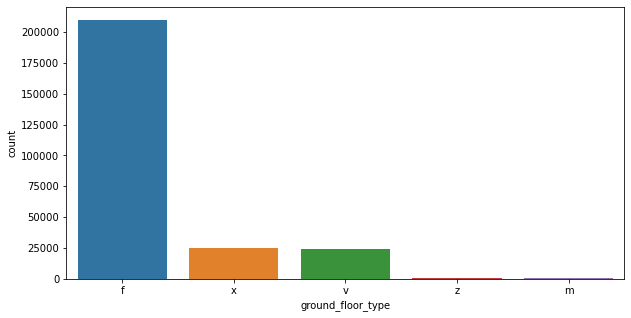

In [23]:
sns.countplot(train['ground_floor_type'])

<AxesSubplot:xlabel='position', ylabel='count'>

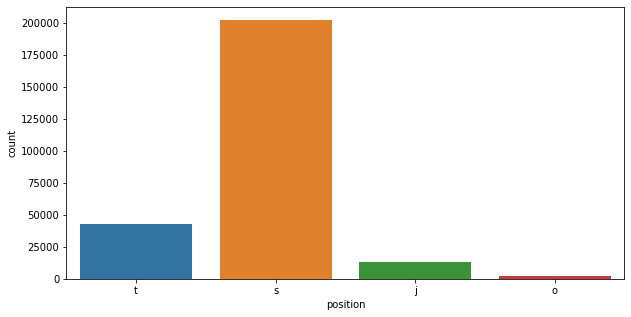

In [24]:
sns.countplot(train['position'])

There aren't any significant observations from last 6 charts.

geo_level_1_id, geo_level_2_id, geo_level_3_id: <br>geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). <br>Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567.

In [25]:
train.drop_duplicates(['geo_level_1_id','geo_level_2_id','geo_level_3_id'])[['geo_level_1_id','geo_level_2_id','geo_level_3_id']]

,geo_level_1_id,geo_level_2_id,geo_level_3_id
0,6,487,12198
1,8,900,2812
2,21,363,8973
3,22,418,10694
4,11,131,1488
...,...,...,...
259662,29,1360,7039
259953,15,1400,8947
260135,19,160,3152
260372,13,730,5276


In [26]:
train[train['geo_level_1_id']==6].sort_values(['geo_level_2_id'])

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
141852,678838,6,8,5251,3,15,9,7,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
75336,225434,6,8,3191,2,10,5,7,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
153935,627592,6,8,11610,3,10,6,8,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,0,0,0,0,0,0,0,0,0,0,0,0,1
120850,756181,6,8,9957,3,45,9,10,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
237832,783747,6,8,11610,3,90,7,7,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133240,121253,6,1385,7963,2,45,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
132995,451953,6,1385,4562,2,10,4,7,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
75049,977660,6,1385,7963,2,15,4,7,t,r,n,f,x,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
254496,249709,6,1385,4562,2,10,6,7,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2


##### Extracting Hidden Features from the Geo Ids
We will pass the geo_level_3_id as input to a three layer NN and train on geo_level_2_id and geo_level_1_id and then extract the second hidden layer and use it as a feature in our model. 

In [27]:
geo1 = np.array(pd.get_dummies(pd.concat([train["geo_level_1_id"], test["geo_level_1_id"]])))
geo2 = np.array(pd.get_dummies(pd.concat([train["geo_level_2_id"], test["geo_level_2_id"]])))
geo3 = np.array(pd.get_dummies(pd.concat([train["geo_level_3_id"], test["geo_level_3_id"]])))

In [28]:
inputs = Input(shape=geo3.shape[1])
x3 = Dense(48)(inputs)
x4 = Dense(24)(x3)
x2 = Dense(geo2.shape[1], activation='sigmoid')(x4)
x1 = Dense(geo1.shape[1], activation='sigmoid')(x4)
model = Model(inputs, [x2,x1])
model.compile(loss="binary_crossentropy", optimizer="adam")

In [29]:
model.fit(x = geo3, y = [geo2, geo1], batch_size=256, epochs=10)

Epoch 1/10
1358/1358 [==============================] - 26s 18ms/step - loss: 0.1715 - dense_2_loss: 0.0384 - dense_3_loss: 0.1331
Epoch 2/10
1358/1358 [==============================] - 25s 18ms/step - loss: 0.0243 - dense_2_loss: 0.0049 - dense_3_loss: 0.0194
Epoch 3/10
1358/1358 [==============================] - 25s 18ms/step - loss: 0.0062 - dense_2_loss: 0.0037 - dense_3_loss: 0.0025
Epoch 4/10
1358/1358 [==============================] - 24s 18ms/step - loss: 0.0039 - dense_2_loss: 0.0032 - dense_3_loss: 6.9701e-04 3s - loss
Epoch 5/10
1358/1358 [==============================] - 25s 18ms/step - loss: 0.0028 - dense_2_loss: 0.0026 - dense_3_loss: 2.2528e-04
Epoch 6/10
1358/1358 [==============================] - 24s 18ms/step - loss: 0.0017 - dense_2_loss: 0.0016 - dense_3_loss: 7.5188e-05 1s - loss: 0.0017 - dense_2_loss: 0.0016 -
Epoch 7/10
1358/1358 [==============================] - 24s 17ms/step - loss: 7.5957e-04 - dense_2_loss: 7.2985e-04 - dense_3_loss: 2.9720e-05 2s - l

In [30]:
# "xtract Intermediate Layer
from keras import backend
intermediate_layer = backend.function([model.layers[0].input],[model.layers[2].output])

In [31]:
# Now we will input the geo3 id and extract the intermediate layer for test and train
int_layer_train = []
for record in geo3[0:train.shape[0]]:
    layer_feat = intermediate_layer([record.reshape(1,-1)])[0][0]
    int_layer_train.append(layer_feat)
layer_feat_train = np.squeeze(int_layer_train)

int_layer_test = []
for record in geo3[train.shape[0]:]:
    layer_feat = intermediate_layer([record.reshape(1,-1)])[0][0]
    int_layer_test.append(layer_feat)
layer_feat_test = np.squeeze(int_layer_test)

In [32]:
## Adding the 2nd hidden layer as a feature
train_model = train.copy()
train_model.drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id','damage_grade'],axis=1, inplace = True)
train_model = train_model.assign(
                               geof01 = layer_feat_train[:,0],
                               geof02 = layer_feat_train[:,1],
                               geof03 = layer_feat_train[:,2],  
                               geof04 = layer_feat_train[:,3],
                               geof05 = layer_feat_train[:,4],    
                               geof06 = layer_feat_train[:,5],
                               geof07 = layer_feat_train[:,6],
                               geof08 = layer_feat_train[:,7],
                               geof09 = layer_feat_train[:,8],
                               geof10 = layer_feat_train[:,9],
                               geof11 = layer_feat_train[:,10],  
                               geof12 = layer_feat_train[:,11],
                               geof13 = layer_feat_train[:,12],    
                               geof14 = layer_feat_train[:,13],
                               geof15 = layer_feat_train[:,14],
                               geof16 = layer_feat_train[:,15],
                               geof17 = layer_feat_train[:,16],
                               geof18 = layer_feat_train[:,17],
                               geof19 = layer_feat_train[:,18],  
                               geof20 = layer_feat_train[:,19],
                               geof21 = layer_feat_train[:,20],    
                               geof22 = layer_feat_train[:,21],
                               geof23 = layer_feat_train[:,22],
                               geof24 = layer_feat_train[:,23]
)

train_model = pd.get_dummies(train_model)
train_model.head()

,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geof01,geof02,geof03,geof04,geof05,geof06,geof07,geof08,geof09,geof10,geof11,geof12,geof13,geof14,geof15,geof16,geof17,geof18,geof19,geof20,geof21,geof22,geof23,geof24,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,802906,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-5.803061,3.098706,10.901978,6.077253,-0.967820,-3.442320,3.298519,-3.324534,9.208565,12.711576,-10.049640,-10.396002,-10.415866,10.491765,2.946638,5.166451,6.042978,9.546430,-5.542098,-6.923812,-0.499658,-7.480357,0.192904,0.193758,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,28830,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-3.610065,3.184370,7.733287,3.811644,-4.747585,-3.741991,2.326638,-1.359608,-4.645730,3.460423,-7.845341,-0.840007,-10.012897,5.507674,12.947607,6.411430,3.773404,6.842358,-7.622941,-7.834162,12.006433,1.016389,11.271940,3.482288,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,94947,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-3.859693,11.337086,1.452688,5.410280,-9.581602,-6.893523,8.296013,-7.846125,7.750265,-2.194140,-4.377763,-4.180310,1.174732,7.929326,11.113686,9.473392,13.592504,11.677399,-4.934209,-0.382050,16.313288,-13.589252,7.230461,6.270483,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,590882,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-7.548319,10.428510,5.558324,5.690939,-9.960674,1.319095,5.211940,-4.500490,2.479610,-2.162112,-5.627273,-5.334674,-4.069190,11.360409,9.393085,7.343918,3.110450,13.309060,-4.888076,0.615582,15.497483,-7.081115,2.718182,3.102359,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,201944,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-6.088316,9.080923,-2.145373,9.363265,-6.303188,-8.410694,8.587024,-0.895992,3.788660,13.425709,-3.863416,-11.853451,-6.656220,12.537404,14.777839,0.946849,4.099126,2.442175,-11.736635,-12.245073,9.493823,1.848953,8.828471,3.651651,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [33]:
## Adding the 2nd hidden layer as a feature
test_model = test.copy()
test_model.drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'],axis=1, inplace = True)
test_model = test_model.assign(
                               geof1 = layer_feat_test[:,0],
                               geof2 = layer_feat_test[:,1],
                               geof3 = layer_feat_test[:,2],  
                               geof4 = layer_feat_test[:,3],
                               geof5 = layer_feat_test[:,4],    
                               geof6 = layer_feat_test[:,5],
                               geof7 = layer_feat_test[:,6],
                               geof8 = layer_feat_test[:,7],
                               geof09 = layer_feat_test[:,8],
                               geof10 = layer_feat_test[:,9],
                               geof11 = layer_feat_test[:,10],  
                               geof12 = layer_feat_test[:,11],
                               geof13 = layer_feat_test[:,12],    
                               geof14 = layer_feat_test[:,13],
                               geof15 = layer_feat_test[:,14],
                               geof16 = layer_feat_test[:,15],
                               geof17 = layer_feat_test[:,16],
                               geof18 = layer_feat_test[:,17],
                               geof19 = layer_feat_test[:,18],  
                               geof20 = layer_feat_test[:,19],
                               geof21 = layer_feat_test[:,20],    
                               geof22 = layer_feat_test[:,21],
                               geof23 = layer_feat_test[:,22],
                               geof24 = layer_feat_test[:,23])

test_model = pd.get_dummies(test_model)
test_model.head()

,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geof1,geof2,geof3,geof4,geof5,geof6,geof7,geof8,geof09,geof10,geof11,geof12,geof13,geof14,geof15,geof16,geof17,geof18,geof19,geof20,geof21,geof22,geof23,geof24,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,300051,3,20,7,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-3.629347,9.597056,4.468788,4.606049,-10.477608,-0.987922,6.689130,-9.411735,9.266926,-1.913247,2.380986,-8.554474,-4.708014,-0.501661,9.416873,8.990216,6.305450,2.108960,-4.227764,-5.706021,8.200913,-1.472224,2.190653,10.821242,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,99355,2,25,13,5,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,-2.891740,-2.011754,11.004341,6.182572,0.072496,-5.435108,2.962778,-5.012771,5.370439,9.778690,-5.264543,-2.346961,-6.844484,4.403487,3.756889,3.423186,8.991030,3.789282,-1.115864,-6.231320,0.311130,-10.653564,2.722846,3.263103,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,890251,2,5,4,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-5.488830,7.830533,2.249696,5.132494,-7.837958,1.170095,5.377450,-3.308669,0.296042,-0.518182,1.622565,-2.632850,-2.450166,7.008404,8.773222,4.067180,2.528384,6.616230,-3.642142,-2.635741,12.838025,-1.743375,2.224662,3.763875,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,745817,1,0,19,3,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,0,-15.885705,3.168852,16.450863,6.931746,-8.891227,6.995783,14.331003,-13.848783,4.480953,11.589211,0.454101,4.384715,-6.263246,4.280746,4.966405,7.499183,7.662702,6.444627,-9.014088,-12.595131,-0.219399,-12.306377,3.780189,13.238117,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,421793,3,15,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-5.725495,6.000841,7.767392,7.596821,-10.038702,3.753774,3.424894,-6.700290,9.341660,5.543573,-1.632266,-6.094152,-6.451231,5.482560,3.648583,11.461147,2.490962,3.952349,-1.450614,-5.156419,5.765188,-0.191083,-2.003436,12.750172,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [34]:
train_model.drop('building_id',axis=1,inplace=True)
train_labels.drop('building_id',axis=1,inplace=True)

In [35]:
train_model = np.array(train_model)
train_labels = np.array(train_labels)
train_labels = train_labels - 1

In [36]:
X_train, X_val, Y_train, Y_val = train_test_split(train_model,train_labels,random_state=42)

In [45]:
train_data = lgb.Dataset(X_train, Y_train)
val_data   = lgb.Dataset(X_val, Y_val)

In [ ]:
## Parameters were manually tuned based on F1-Score of validation data
lgb_params = {
        "objective" : "multiclass",
        "num_class":3,
        "metric" : "multi_error",
        "boosting": 'gbdt',
        "max_depth" : -1,
        "num_leaves" : 30,
        "learning_rate" : 0.05,
        "feature_fraction" : 0.6
    }

## LightGBM model is used for computational efficiency
lgb_model = lgb.train(lgb_params,
                      train_data,
                      20000,
                      valid_sets = [val_data],
                      early_stopping_rounds=3000
                     )

In [47]:
Y_pred = lgb_model.predict(X_val)

In [48]:
Y_pred_binary = []
for i, val in enumerate(Y_pred):
    loc = np.array(val).argmax(axis=0)
    k = list(np.zeros((len(val))))
    k[loc]=1
    Y_pred_binary.append(k)

In [49]:
print("F1-MICRO SCORE: ", f1_score(np.array(pd.get_dummies(Y_val.reshape(1,-1)[0])), Y_pred_binary, average='micro'))

F1-MICRO SCORE:  0.7505487252689904


In [50]:
test_labels = test_model['building_id']
test_model.drop(['building_id'],axis = 1, inplace=True)

In [51]:
Y_pred = lgb_model.predict(test_model)

In [52]:
Y_pred_binary = []
for i, val in enumerate(Y_pred):
    loc = np.array(val).argmax(axis=0)
    k = list(np.zeros((len(val))))
    k[loc]=1
    Y_pred_binary.append(k)

In [53]:
Y_pred_binary = np.dot(np.array(Y_pred_binary),[1,2,3])

In [54]:
Y_pred_binary

array([3., 2., 2., ..., 2., 2., 1.])

In [55]:
Result = pd.DataFrame()
Result['building_id'] = test_labels
Result['damage_grade'] = np.int32(Y_pred_binary)

In [56]:
Result.head(3)

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2


In [57]:
Result.to_csv('Result_V9.csv',index=False)